In [1]:
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class Easy21:

    def __init__(self, max_length=1000):
        self.max_length = max_length


    def reset(self):  #to be called before each episode
        
        #drawing the first black card for player and dealer and adding it to their sum
        self.player_first_card_val = np.random.choice(10) + 1 
        self.dealer_first_card_val = np.random.choice(10) + 1 

        self.player_sum = self.player_first_card_val     
        self.dealer_sum = self.dealer_first_card_val 
        
        #state is defined as the dealer's initial card and the player's sum
        self.state = [self.dealer_first_card_val, self.player_sum]

        # Initialization for another game to be played 
        self.player_goes_bust = False   
        self.dealer_goes_bust = False

        self.ret = 0   
        self.terminal = False
        # self.t = 0

        return self.state #return the initial state of a game


    def step(self, action): #takes in state and player's action and outputs player's reward and next state
        # action 1: hit   0: stick
        # color: 1: black   -1: red
        
        r = 0   #Default
        
        if action == 1:  # Action passed in is to hit, doesn't end in terminal state unless player goes bust
            
            # Drawing the player's card and updating the player's sum
            self.player_card_val = np.random.choice(10) + 1   
            self.player_card_col = np.random.choice([-1, 1], p=[1./3., 2./3.])  

            self.player_sum += (self.player_card_val * self.player_card_col)
            
            # Checking if the player has gone bust
            self.player_goes_bust = self.check_go_bust(self.player_sum)
            if self.player_goes_bust == 1:   
                r = -1                      # Player loses, reward is -1
                self.terminal = True        # Flag terminal state

        if action == 0:  # Action passed in is to stick, always ends in terminal state
            
            #The dealer plays his entire game and ends up either bust or between 17 and 21
            while self.dealer_sum < 17 and self.dealer_goes_bust == 0: # Keep hitting while sum under 17 and not bust
                # Drawing the dealer's card and updating the dealer's sum
                self.dealer_card_val = np.random.choice(10) + 1
                self.dealer_card_col = np.random.choice([-1, 1], p=[1./3., 2./3.])

                self.dealer_sum += (self.dealer_card_val * self.dealer_card_col)
                
                #check if gone bust
                self.dealer_goes_bust = self.check_go_bust(self.dealer_sum)
            
            # Dealer gone bust   
            if self.dealer_goes_bust == 1:  
                r = 1                       # Dealer loses, reward is 1
                self.terminal = True        # Flag terminal state

            # No one's gone bust, dealer sum between 17 and 21, player sum between 1 and 21  
            if self.terminal == 0:        
                if self.dealer_sum == self.player_sum: # Draw
                    self.terminal = True               #Flag terminal state
                elif self.dealer_sum > self.player_sum: 
                    r = -1                             # Player loses
                    self.terminal = True               #Flag terminal state
                elif self.dealer_sum < self.player_sum:
                    r = 1                              # Player wins
                    self.terminal = True               #Flag terminal state

                    
        #self.t += 1     # number of steps in an episode
        self.ret += r   # Return (accumulated reward) from episode
        
        if self.terminal: 
            return 'Terminal', r, self.terminal, self.ret
            
        else:
            self.state[1] = self.player_sum
            return self.state, r, self.terminal, self.ret

    def check_go_bust(self, Sum): #takes in a sum and returns true if gone bust
        return bool(Sum > 21 or Sum < 1)

In [3]:
## Monte Carlo -- one episode
def monte_carlo(Q, Returns, count_state):

    actions = []
    rewards = []
    
    # Initialise state
    s = env.reset()
    states = [s.copy()] # List of states/trace

    # Run an episode
    while True:
        # Choose action from epsilon greedy policy
        action_greedy = Q[s[0]-1, s[1]-1, :].argmax()  # Action for maximum state action pair value given a state 
        count_state[s[0]-1, s[1]-1] += 1   # Updating how many times you visited that state 
        epsilon = count_constant / float(count_constant + count_state[s[0]-1, s[1]-1])  # epsilon converges to 0 the more a state is visited 
        action = np.random.choice([action_greedy, 1 - action_greedy], p=[1. - epsilon/2., epsilon/2.])  # Choose the actual action to be taken epsilon-greedily
        actions.append(action)  # Update list of actions associated to trace
        
        # Execute action and observe next state and reward
        s, r, term, ret = env.step(action=action)
        rewards.append(r)  # update list of rewards associated to trace 

        if term: break
        else: 
            states.append(s.copy())   # update trace
    

    # Update values of state-action pairs visited in trace, First visit MC
    state_action_pair_list = []
    for t in range(len(states)):   #For each state in the trace

        first_card_of_dealer = states[t][0]
        sum_of_player = states[t][1]
        state_action_pair = [first_card_of_dealer, sum_of_player, actions[t]]

        state_action_pair_return = np.sum(rewards[t:])  # is actually the terminal state's reward 
        
        # Update Q function
        if state_action_pair not in state_action_pair_list:
            Q[first_card_of_dealer-1, sum_of_player-1, actions[t]] = Q[first_card_of_dealer-1, sum_of_player-1, actions[t]] + (1/count_state[first_card_of_dealer-1, sum_of_player-1])*(state_action_pair_return - Q[first_card_of_dealer-1, sum_of_player-1, actions[t]])       
        
        state_action_pair_list.append(state_action_pair)
        
    
    return Q, Returns, count_state, ret

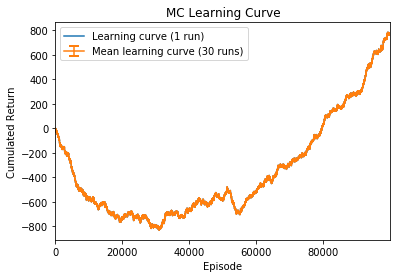

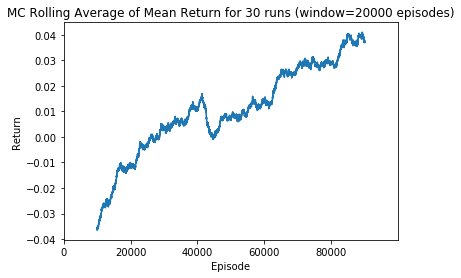

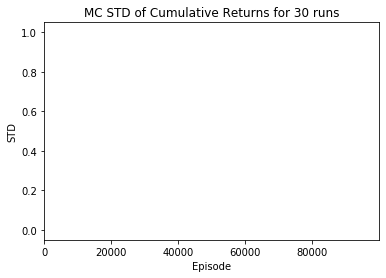

In [4]:
## Monte Carlo

n_episodes = 100000

data = {'episode' : range(1, n_episodes+1)} #For plotting purposes
df1 = pd.DataFrame(data)                    #For plotting purposes
df = pd.DataFrame(data)                     #For plotting purposes

for run in range(1):                        #For plotting purposes (execute many runs)
    Q_MC = np.zeros([10, 21, 2]) # Q(s, a)
    Returns = np.zeros([10, 21, 2]) # empirical first-visit returns  
    #count_state_action = np.zeros([10, 21, 2], dtype=int) # N(s, a)
    count_state = np.zeros([10, 21], dtype=int) # N(s)
    count_constant = 100

    env = Easy21()

    rets =[]

    for i_epi in range(n_episodes):
        Q_MC, Returns, count_state, ret = monte_carlo(Q_MC, Returns, count_state)
        rets.append(ret)

    
###### Plotting returns, mean and std vs. episodes#####################################
    run_number = 'run' + str(run)
    df1[run_number] = np.cumsum(rets)
    df[run_number] = rets
    df1['mean'] = df1[df1.columns.difference(['episode', 'mean', 'std'])].mean(axis=1)
    df1['std'] = df1[df1.columns.difference(['episode', 'mean', 'std'])].std(axis=1)
    df['mean'] = df[df.columns.difference(['episode', 'mean', 'std', 'MA'])].mean(axis=1)
    
plt.figure(1)
plt.title('MC Learning Curve')
plt.ylabel('Cumulated Return')
plt.xlabel('Episode')
df1[run_number].plot(label='Learning curve (1 run)')
df1['mean'].plot(yerr=df1['std'], errorevery=5000, capsize=5, markeredgewidth=2, label='Mean learning curve (30 runs)')
plt.legend(loc='upper left')

plt.figure(2)
plt.title('MC Rolling Average of Mean Return for 30 runs (window=20000 episodes)')
plt.ylabel('Return')
plt.xlabel('Episode')
df['MA'] = df['mean'].rolling(window=20000,center=True).mean().plot()

plt.figure(3)
plt.title('MC STD of Cumulative Returns for 30 runs')
plt.ylabel('STD')
plt.xlabel('Episode')
df1['std'].plot()

####################################################################################

V_MC = Q_MC.max(axis=2) # Value function attributes to each state the value of the action with max value

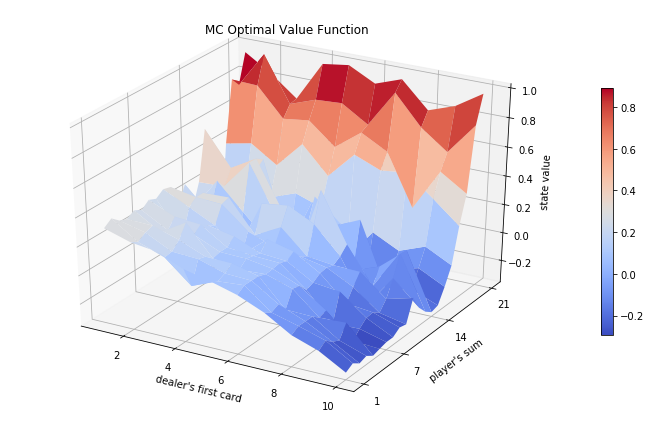

In [14]:
## Monte Carlo -- plot
s1 = np.arange(10)+1
s2 = np.arange(21)+1
ss1, ss2 = np.meshgrid(s1, s2, indexing='ij')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(ss1, ss2, V_MC, cmap=cm.coolwarm)

ax.set_xlabel("dealer's first card")
ax.set_ylabel("player's sum")
ax.set_zlabel("state value")
plt.title('MC Optimal Value Function')
plt.yticks([1, 5, 10])
plt.yticks([1, 7, 14, 21])
fig.colorbar(surf, shrink=0.6)
fig.tight_layout()

# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)

plt.show()

In [6]:
## SARSA -- one_episode 
def SARSA(Q, count_state):
    
    # Initialise state
    s = env.reset()  
    
    # Pick initial action a from epsilon greedy policy
    action_greedy = Q[s[0]-1, s[1]-1, :].argmax()  
    count_state[s[0]-1, s[1]-1] += 1 
    epsilon = count_constant / float(count_constant + count_state[s[0]-1, s[1]-1])  
    a = np.random.choice([action_greedy, 1 - action_greedy], p=[1. - epsilon/2., epsilon/2.])  
    
    # Run an episode
    while True:
        
        # From state s execute action a and observe next state s' and reward R
        sp, r, term, ret = env.step(action=a)
        
        if not term:
            
            # Pick future action a' (action at next state) from epsilon greedy policy
            action_greedy_p = Q[sp[0]-1, sp[1]-1, :].argmax() 
            count_state[sp[0]-1, sp[1]-1] += 1  
            epsilon = count_constant / float(count_constant + count_state[sp[0]-1, sp[1]-1]) 
            ap = np.random.choice([action_greedy_p, 1 - action_greedy_p], p=[1. - epsilon/2., epsilon/2.]) 

            # Update value function using Q(s,a), Q(s',a') and R. Alpha is 1/(1+N(s))
            Q[s[0]-1, s[1]-1, a] = Q[s[0]-1, s[1]-1, a] + (1/(1+count_state[s[0]-1, s[1]-1]))*(r + gamma * Q[sp[0]-1, sp[1]-1, ap] -  Q[s[0]-1, s[1]-1, a])

            s=sp
            a=ap
        
        if term: 

            Q[s[0]-1, s[1]-1, a] = Q[s[0]-1, s[1]-1, a] + (1/(1+count_state[s[0]-1, s[1]-1]))* (r + gamma * 0 -  Q[s[0]-1, s[1]-1, a])  # No value in being in terminal state (no future actions or returns from that state)
            break
        
        

    
    return Q, count_state, ret

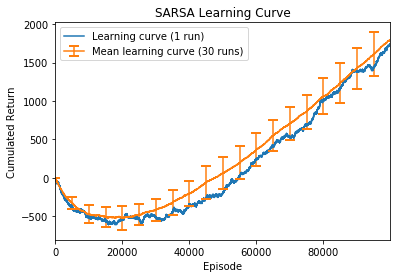

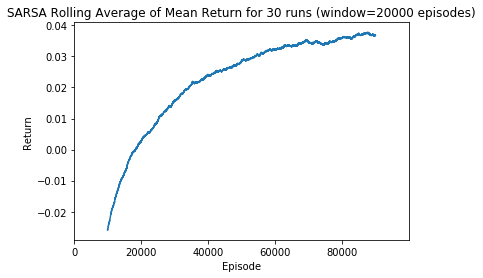

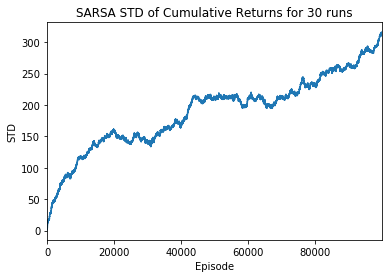

In [7]:
## SARSA

n_episodes = 100000

data = {'episode' : range(1, n_episodes+1)} #For plotting purposes
df3 = pd.DataFrame(data)                    #For plotting purposes
df2 = pd.DataFrame(data)                     #For plotting purposes

for run in range(30):                        #For plotting purposes (execute many runs)
    Q_SARSA = np.zeros([10, 21, 2]) # Q(s, a) 
    count_state = np.zeros([10, 21], dtype=int) # N(s)
    count_constant = 100
    #alpha = 1
    gamma = 1


    #n_episodes = 100000
    env = Easy21()

    rets =[]

    for i_epi in range(n_episodes):
        Q_SARSA, count_state, ret = SARSA(Q_SARSA, count_state)
        rets.append(ret)


###### Plotting returns, mean and std vs. episodes#####################################
    run_number = 'run' + str(run)
    df3[run_number] = np.cumsum(rets)
    df2[run_number] = rets
    df3['mean'] = df3[df3.columns.difference(['episode', 'mean', 'std'])].mean(axis=1)
    df3['std'] = df3[df3.columns.difference(['episode', 'mean', 'std'])].std(axis=1)
    df2['mean'] = df2[df2.columns.difference(['episode', 'mean', 'MA'])].mean(axis=1)
    
plt.figure(1)
plt.title('SARSA Learning Curve')
plt.ylabel('Cumulated Return')
plt.xlabel('Episode')
df3[run_number].plot(label='Learning curve (1 run)')
df3['mean'].plot(yerr=df3['std'], errorevery=5000, capsize=5, markeredgewidth=2, label='Mean learning curve (30 runs)')
plt.legend(loc='upper left')

plt.figure(2)
plt.title('SARSA Rolling Average of Mean Return for 30 runs (window=20000 episodes)')
plt.ylabel('Return')
plt.xlabel('Episode')
df2['MA'] = df2['mean'].rolling(window=20000,center=True).mean().plot()

plt.figure(3)
plt.title('SARSA STD of Cumulative Returns for 30 runs')
plt.ylabel('STD')
plt.xlabel('Episode')
df3['std'].plot()

####################################################################################


V_SARSA = Q_SARSA.max(axis=2) # Value function attributes to each state the value of the action with max value

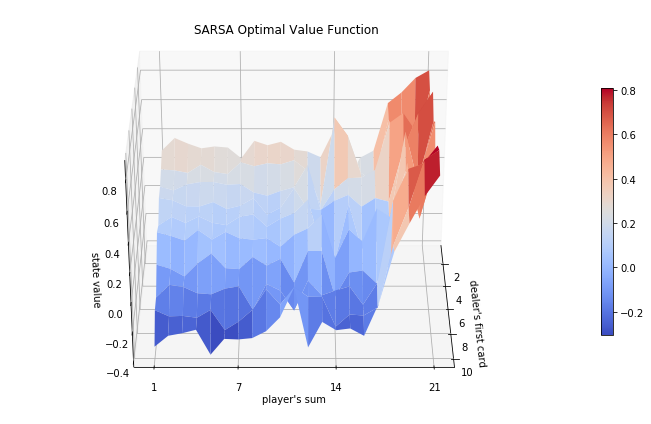

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [8]:
## SARSA -- plot
s1 = np.arange(10)+1
s2 = np.arange(21)+1
ss1, ss2 = np.meshgrid(s1, s2, indexing='ij')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(ss1, ss2, V_SARSA, cmap=cm.coolwarm)

ax.set_xlabel("dealer's first card")
ax.set_ylabel("player's sum")
ax.set_zlabel("state value")
plt.title('SARSA Optimal Value Function')
plt.yticks([1, 5, 10])
plt.yticks([1, 7, 14, 21])
fig.colorbar(surf, shrink=0.6)
fig.tight_layout()

for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

plt.show()

In [9]:
## Q-learning -- one_episode 
def Qlearn(Q, count_state):
    
    # Initialise state
    s = env.reset()
    
    # Pick initial action a from epsilon greedy policy
    action_greedy = Q[s[0]-1, s[1]-1, :].argmax()  
    count_state[s[0]-1, s[1]-1] += 1 
    epsilon = count_constant / float(count_constant + count_state[s[0]-1, s[1]-1]) 
    a = np.random.choice([action_greedy, 1 - action_greedy], p=[1. - epsilon/2., epsilon/2.])

    # Run an episode
    while True:
        
        # From state s execute action a and observe next state s' and reward R
        sp, r, term, ret = env.step(action=a)
        
        if not term:
            
            # Pick future action a' (action at next state) from epsilon greedy policy and note greedy action A
            action_greedy = Q[sp[0]-1, sp[1]-1, :].argmax()  #Using the actual values of self.state as indices 
            count_state[sp[0]-1, sp[1]-1] += 1   #Marking how many times you visited that state 
            epsilon = count_constant / float(count_constant + count_state[sp[0]-1, sp[1]-1])  # Makes e bigger, so exploring for longer and more, slower to tend towards 0 
            ap = np.random.choice([action_greedy, 1 - action_greedy], p=[1. - epsilon/2., epsilon/2.])  # [1, 0] or [0,1] correlates to the probabilities in the corresponding slots in the second argument 

            # Update value function using Q(s,a), Q(s',A) and R. Alpha is 1/(1+N(s))
            Q[s[0]-1, s[1]-1, a] = Q[s[0]-1, s[1]-1, a] + (1/(1+count_state[s[0]-1, s[1]-1]))*(r + gamma * Q[sp[0]-1, sp[1]-1, action_greedy] -  Q[s[0]-1, s[1]-1, a])

            s=sp
            a=ap
        
        if term: 

            Q[s[0]-1, s[1]-1, a] = Q[s[0]-1, s[1]-1, a] + (1/(1+count_state[s[0]-1, s[1]-1]))* (r + gamma * 0 -  Q[s[0]-1, s[1]-1, a])  # No value in being in terminal state. (no future returns from that state)
            break
        
        

    
    return Q, count_state, ret

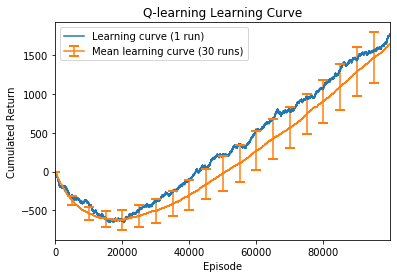

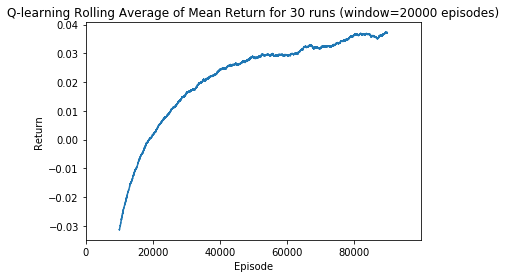

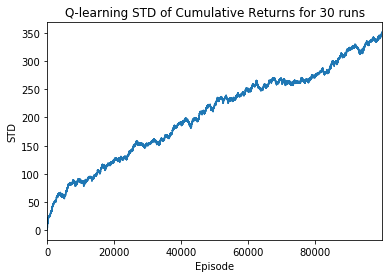

In [10]:
## Q-learning
n_episodes = 100000

data = {'episode' : range(1, n_episodes+1)} #For plotting purposes
df5 = pd.DataFrame(data)                    #For plotting purposes
df4 = pd.DataFrame(data)                     #For plotting purposes

for run in range(30):                        #For plotting purposes (execute many runs)
    Q_learn = np.zeros([10, 21, 2]) # Q(s, a)
    count_state = np.zeros([10, 21], dtype=int) # N(s)
    count_constant = 100
    #alpha = 0.5
    gamma = 1


    #n_episodes = 100000
    env = Easy21()

    rets =[]

    for i_epi in range(n_episodes):
        Q_learn, count_state, ret = Qlearn(Q_learn, count_state)
        rets.append(ret)

###### Plotting returns, mean and std vs. episodes#####################################
    run_number = 'run' + str(run)
    df5[run_number] = np.cumsum(rets)
    df4[run_number] = rets
    df5['mean'] = df5[df5.columns.difference(['episode', 'mean', 'std'])].mean(axis=1)
    df5['std'] = df5[df5.columns.difference(['episode', 'mean', 'std'])].std(axis=1)
    df4['mean'] = df4[df4.columns.difference(['episode', 'mean', 'MA'])].mean(axis=1)
    
plt.figure(1)
plt.title('Q-learning Learning Curve')
plt.ylabel('Cumulated Return')
plt.xlabel('Episode')
df5[run_number].plot(label='Learning curve (1 run)')
df5['mean'].plot(yerr=df5['std'], errorevery=5000, capsize=5, markeredgewidth=2, label='Mean learning curve (30 runs)')
plt.legend(loc='upper left')

plt.figure(2)
plt.title('Q-learning Rolling Average of Mean Return for 30 runs (window=20000 episodes)')
plt.ylabel('Return')
plt.xlabel('Episode')
df4['MA'] = df4['mean'].rolling(window=20000,center=True).mean().plot()

plt.figure(3)
plt.title('Q-learning STD of Cumulative Returns for 30 runs')
plt.ylabel('STD')
plt.xlabel('Episode')
df5['std'].plot()

####################################################################################


V_learn = Q_learn.max(axis=2) # Value function attributes to each state the value of the action with max value

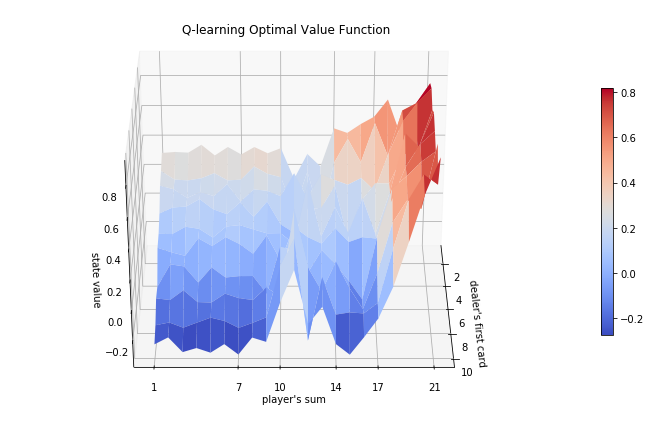

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [11]:
## Q-learning -- plot
s1 = np.arange(10)+1
s2 = np.arange(21)+1
ss1, ss2 = np.meshgrid(s1, s2, indexing='ij')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(ss1, ss2, V_learn, cmap=cm.coolwarm)

ax.set_xlabel("dealer's first card")
ax.set_ylabel("player's sum")
ax.set_zlabel("state value")
plt.title('Q-learning Optimal Value Function')
plt.yticks([1, 5, 10])
plt.yticks([1, 7, 10, 14, 17, 21])
fig.colorbar(surf, shrink=0.6)
fig.tight_layout()

for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

plt.show()

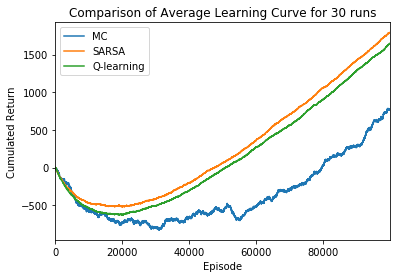

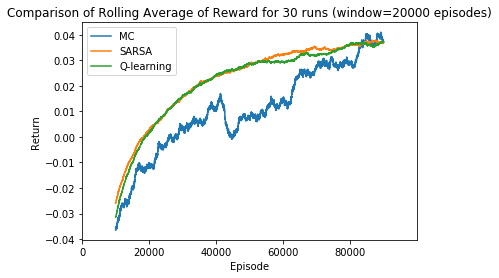

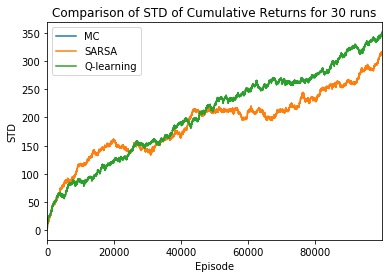

In [12]:
### Comparative plots, all 3 methods###
plt.figure(1)
plt.title('Comparison of Average Learning Curve for 30 runs')
plt.ylabel('Cumulated Return')
plt.xlabel('Episode')
df1['mean'].plot(label='MC')
df3['mean'].plot(label='SARSA')
df5['mean'].plot(label='Q-learning')
plt.legend(loc='upper left')

plt.figure(2)
plt.title('Comparison of Rolling Average of Reward for 30 runs (window=20000 episodes)')
plt.ylabel('Return')
plt.xlabel('Episode')
df['MA'] = df['mean'].rolling(window=20000,center=True).mean().plot(label='MC')
df2['MA'] = df2['mean'].rolling(window=20000,center=True).mean().plot(label='SARSA')
df4['MA'] = df4['mean'].rolling(window=20000,center=True).mean().plot(label='Q-learning')
plt.legend(loc='upper left')

plt.figure(3)
plt.title('Comparison of STD of Cumulative Returns for 30 runs')
plt.ylabel('STD')
plt.xlabel('Episode')
df1['std'].plot(label='MC')
df3['std'].plot(label='SARSA')
df5['std'].plot(label='Q-learning')
plt.legend(loc='upper left')